In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

os.chdir('/content/drive/My Drive/project/waf/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
from pprint import pprint
import pandas as pd
import random

def load_mongo_collection(filename):
    collection = []
    with open(filename) as fd:
        while True:
            line = fd.readline()
            if line:
                data = json.loads(line)
                collection.append(data)
            else:
                break
    
    return collection

attack_log = load_mongo_collection("dataset/csic_attack_log.json") + load_mongo_collection("dataset/modsec_attack_log.json")
# normal_log = load_mongo_collection("./my_normal_log.json")
normal_log = load_mongo_collection("dataset/csic_normal_log.json") + load_mongo_collection("dataset/my_normal_log.json")

# collect all available rules
all_rules = set()
for item in attack_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

for item in normal_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

display(len(all_rules), list(all_rules)[:10])

random.seed(2)
# normal_log = random.sample(normal_log, round(len(attack_log)*5))

print("Len attack_log", len(attack_log))
print("Len normal_log", len(normal_log))

156

[944130,
 943110,
 942100,
 942101,
 921110,
 942110,
 921120,
 942120,
 921130,
 941100]

Len attack_log 23764
Len normal_log 249061


In [3]:
from sklearn.model_selection import train_test_split

def transform_log_item(item):
    global all_rules
    transformed_data = {
        "request_method": item.get("request_method"),
        # "uri": item.get("uri")
    }

    for rule_id in all_rules:
        transformed_data[str(rule_id)] = 0

    for rule_id in map(lambda x: x["id"], item.get("matched_rules")):
        transformed_data[str(rule_id)] = 1

    return transformed_data

cleaned_attack_log = [transform_log_item(x) for x in attack_log]
cleaned_normal_log = [transform_log_item(x) for x in normal_log]

def format_data(logs):
  # convert request_method using one hot encoding
  df = pd.DataFrame(logs)
  temp = pd.get_dummies(df["request_method"], prefix="request_method")
  return pd.concat([df, temp], axis=1).drop(["request_method"], axis=1)


X = format_data(cleaned_attack_log + cleaned_normal_log)
# drop some stupid rule
# 920272, 920273: Validate byte range rules
X = X.drop(columns=['920272', '920273'])

Y = pd.Series([1]*len(cleaned_attack_log) + [0]*len(cleaned_normal_log))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1, stratify=Y)

display("Train set")
display(pd.concat([X_train.head(), pd.DataFrame({"is_attack": Y_train.head()})], axis=1))
display(Y_train.value_counts())

display("Test set")
display(pd.concat([X_test.head(), pd.DataFrame({"is_attack": Y_test.head()})], axis=1))
display(Y_test.value_counts())

'Train set'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,941101,942130,941110,942140,921150,921151,941120,942150,921160,941130,942160,944210,941140,921180,941150,942180,921190,941160,920170,942190,944240,941170,920180,942200,944250,941180,942210,941190,942220,941200,...,200002,941380,933190,930120,942410,951120,930130,942420,942421,950100,933210,942430,942431,942432,932190,920420,942440,942450,920440,942460,950140,942470,920460,942480,920470,942490,942500,942510,942511,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT,is_attack
45343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
251810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
199368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
34789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


0    166870
1     15922
dtype: int64

'Test set'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,941101,942130,941110,942140,921150,921151,941120,942150,921160,941130,942160,944210,941140,921180,941150,942180,921190,941160,920170,942190,944240,941170,920180,942200,944250,941180,942210,941190,942220,941200,...,200002,941380,933190,930120,942410,951120,930130,942420,942421,950100,933210,942430,942431,942432,932190,920420,942440,942450,920440,942460,950140,942470,920460,942480,920470,942490,942500,942510,942511,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT,is_attack
181867,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
33643,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
66891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
270488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
48079,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


0    82191
1     7842
dtype: int64

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=30, class_weight='balanced')
# tree_clf = GridSearchCV(tree_clf, {
#     'max_depth': range(25, 35)
# }, cv=5)
tree_clf.fit(X_train, Y_train)

# tree_clf = tree_clf.best_estimator_
display(tree_clf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

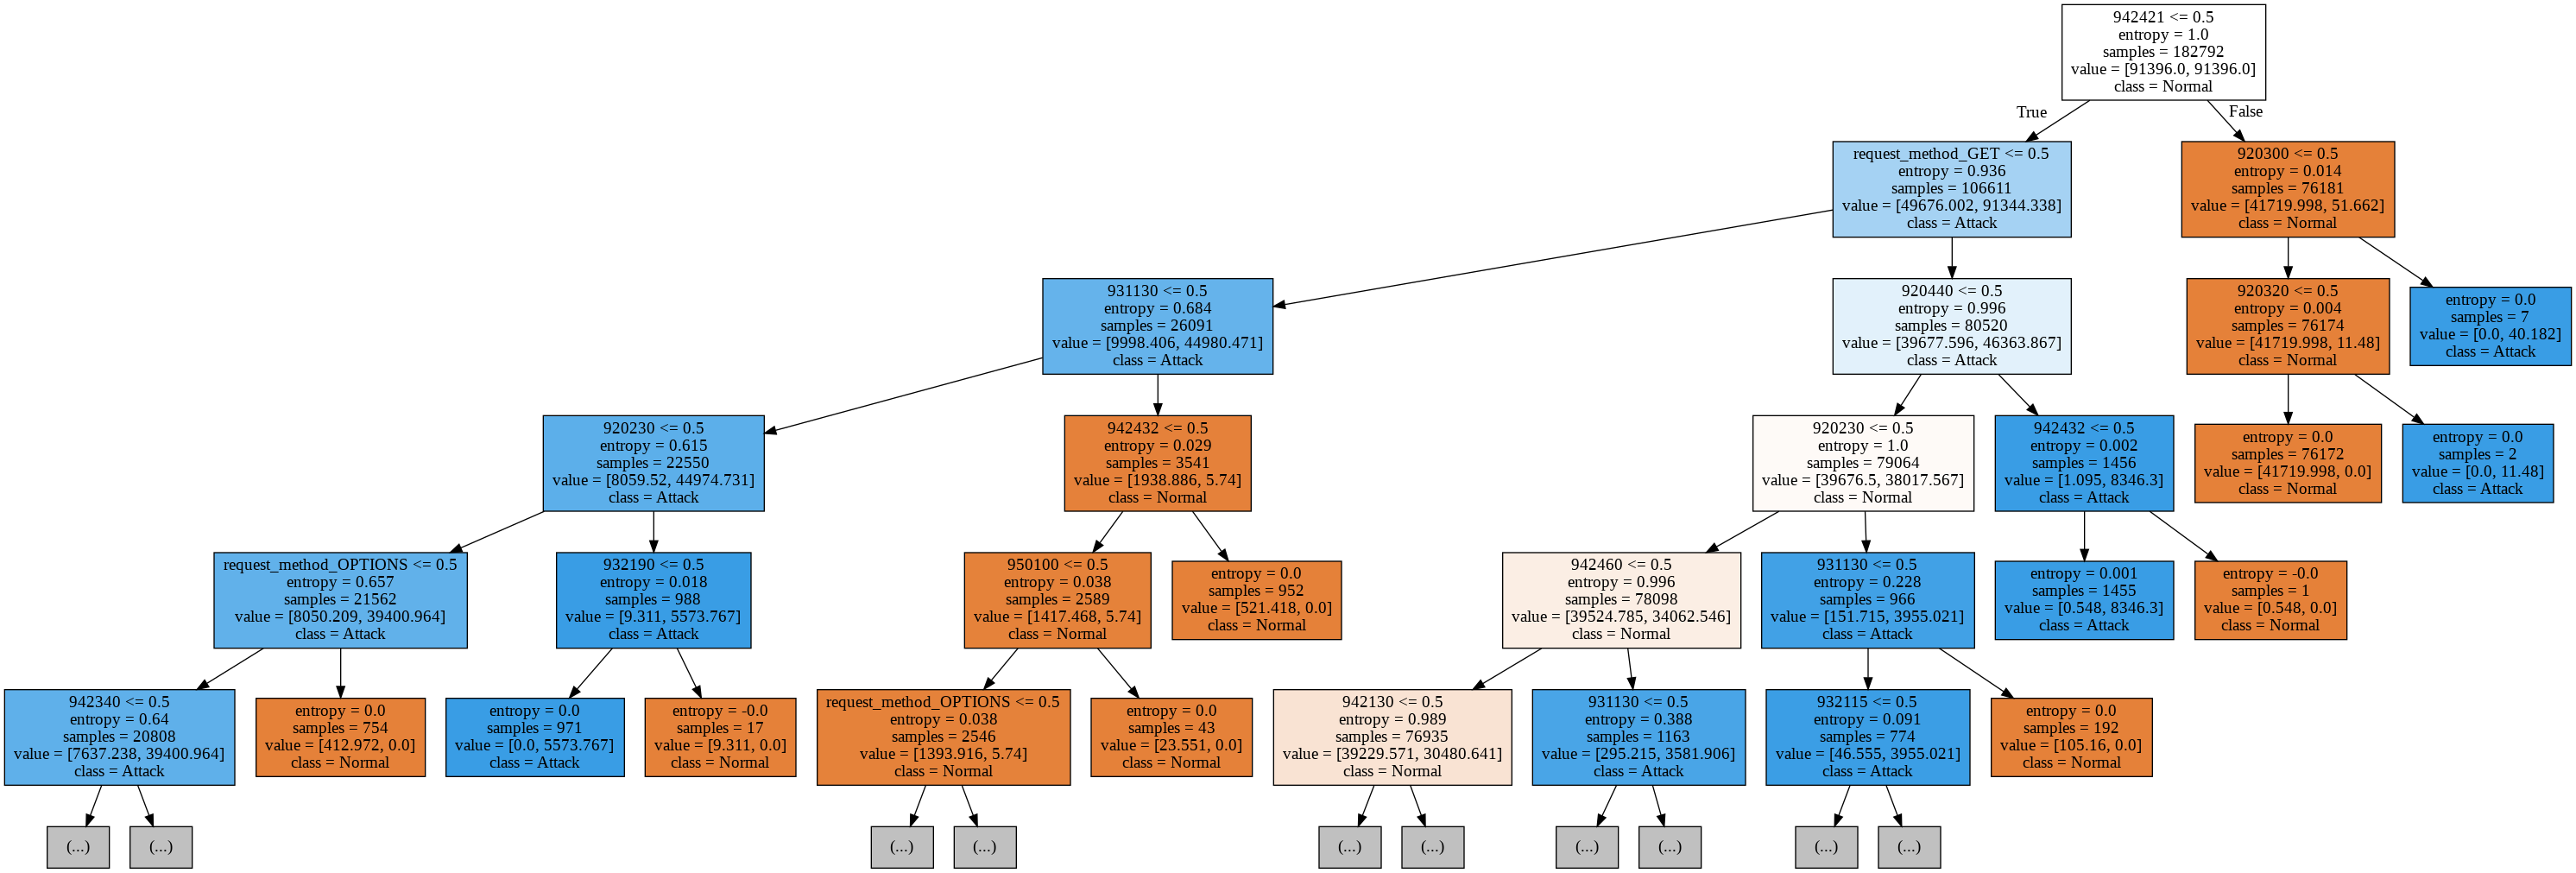

In [5]:
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image

with open("./images/decision_tree.dot", "w") as fd:
    export_graphviz(tree_clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), max_depth=5, filled=True)

check_call("dot -Tpng ./images/decision_tree.dot -o ./images/decision_tree.png", shell=True)

with open("./images/decision_tree_full.dot", "w") as fd:
    export_graphviz(tree_clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), filled=True)

check_call("dot -Tpng ./images/decision_tree_full.dot -o ./images/decision_tree_full.png", shell=True)

img = Image.open("./images/decision_tree.png")
display(img)

In [6]:
train_score = tree_clf.score(X_train, Y_train)
test_score = tree_clf.score(X_test, Y_test)

display(train_score, test_score)

0.9057617401199177

0.9052791754134595

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(criterion="entropy", max_depth=20, n_estimators=93)
# forest_clf = GridSearchCV(forest_clf, {
#     'max_depth': range(25, 35),
#     'n_estimators': range(85, 95)
# }, cv=5)
forest_clf.fit(X_train, Y_train)
# forest_clf = forest_clf.best_estimator_
print(forest_clf)

forest_train_score =  forest_clf.score(X_train, Y_train)
forest_test_score = forest_clf.score(X_test, Y_test)

display(forest_train_score, forest_test_score)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=93,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


0.9509880082279312

0.9517177035087134

array([[75866,  6325],
       [ 2203,  5639]])

array([[82164,    27],
       [ 4320,  3522]])

array([[0.9230451 , 0.0769549 ],
       [0.28092323, 0.71907677]])

array([[9.99671497e-01, 3.28503121e-04],
       [5.50879878e-01, 4.49120122e-01]])

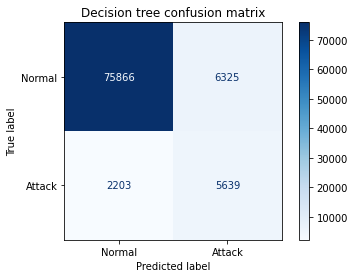

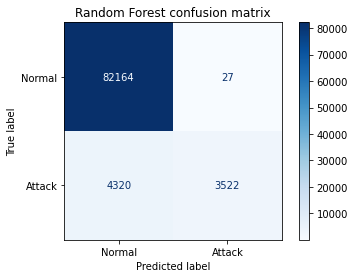

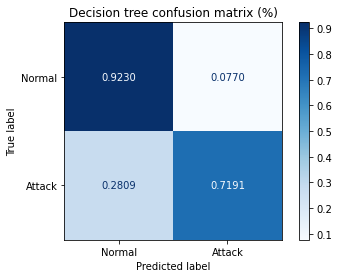

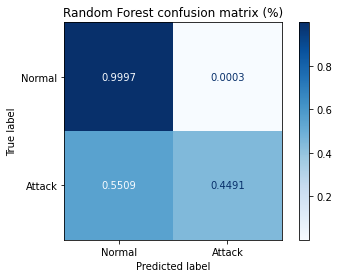

In [8]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = ['Normal', 'Attack']
plot = plot_confusion_matrix(tree_clf, X_test, Y_test, display_labels=class_names, values_format='d', normalize=None, cmap=plt.cm.Blues)
plot.ax_.set_title('Decision tree confusion matrix')
display(plot.confusion_matrix)

plot = plot_confusion_matrix(forest_clf, X_test, Y_test, display_labels=class_names, values_format='d', normalize=None, cmap=plt.cm.Blues)
plot.ax_.set_title('Random Forest confusion matrix')
display(plot.confusion_matrix)

plot = plot_confusion_matrix(tree_clf, X_test, Y_test, display_labels=class_names, values_format='.4f', normalize='true', cmap=plt.cm.Blues)
plot.ax_.set_title('Decision tree confusion matrix (%)')
display(plot.confusion_matrix)

plot = plot_confusion_matrix(forest_clf, X_test, Y_test, display_labels=class_names, values_format='.4f', normalize='true', cmap=plt.cm.Blues)
plot.ax_.set_title('Random Forest confusion matrix (%)')
display(plot.confusion_matrix)

In [9]:
import pickle

# save decision tree and random forest model
with open("saved-models/decision_tree_model.pickle", "wb") as fd:
    pickle.dump(tree_clf, fd)

with open("saved-models/random_forest_model.pickle", "wb") as fd:
    pickle.dump(forest_clf, fd)

# test
# with open("saved-models/random_forest_model.pickle", "rb") as fd:
#     model = pickle.load(fd)

# display(model.score(X_test, Y_test))

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(tree_clf, X, Y, cv=5)
display("Cross validation score of decision tree: ", np.mean(scores))

scores = cross_val_score(forest_clf, X, Y, cv=5)
display("Cross validation score of random forest: ", np.mean(scores))

'Cross validation score of decision tree: '

0.9025932374232566

In [ ]:
X_train.columns

In [ ]:
# convert features to lua table

lua_features = "features = {\n"

for feature in X_test.columns:
    lua_features += f"\t'{feature}',\n"
lua_features += "}"

print(lua_features)
print(len(X_test.columns))